In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retweet-prediction-challenge-2022/baseline.py
/kaggle/input/retweet-prediction-challenge-2022/mean_predictions.txt
/kaggle/input/retweet-prediction-challenge-2022/dummy_baseline.py
/kaggle/input/retweet-prediction-challenge-2022/train.csv
/kaggle/input/retweet-prediction-challenge-2022/evaluation.csv
/kaggle/input/retweet-prediction-challenge-2022/gbr_predictions.txt
/kaggle/input/retweet-prediction-challenge-2022/zero_predictions.txt


In [2]:
all_df = pd.read_csv("/kaggle/input/retweet-prediction-challenge-2022/train.csv")
ev_df = pd.read_csv("/kaggle/input/retweet-prediction-challenge-2022/evaluation.csv")

In [3]:
all_df.head()

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049


In [4]:
print("text",";", "favorites_count",";", "followers_count",";", "retweets_count")
for i, row in all_df[(110 > all_df.favorites_count) & (all_df.favorites_count > 100)][["text", "favorites_count", "followers_count", "retweets_count"]].sample(20).iterrows():
    print(repr(row.text),";", row.favorites_count,";", row.followers_count,";", row.retweets_count)

text ; favorites_count ; followers_count ; retweets_count
'consultants mckinsey pris lee contrôle france' ; 101 ; 57270 ; 65
'lire numéro mars retrouver coordonné usages actuels notion souveraineté entretiennent confusion souveraineté puissance' ; 105 ; 10370 ; 57
'savoir oubliez prendre pourris œufs faire traces odeur' ; 102 ; 4945 ; 18
'établissements fin république moyens riches moyens pauvres macron organise séparatisme riches veux république partout veux réussite enfants' ; 102 ; 68514 ; 45
'adepte communication indirecte emmanuel macron republié lettre français officialisant candidature twitter problème compte président candidat suivi fairplay' ; 103 ; 124789 ; 41
'mépris traitent camp gauche radicale lfi gauche révolutionnaire débattre politique diaboliser caricaturer mutuellement cause désaccords stratégiques' ; 108 ; 8528 ; 7
'semblant militant giflé président juin réjoui' ; 101 ; 41731 ; 43
'prédit meeting besançon soir démocratie vitesses courbettes fascistes écarte arbitrai

In [5]:
ev_df.head()

,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,descendue pourcentage vote,0,85,4442,327,[],[],0,"['presidentielle2022', 'hidalgo']",1647607994000,1184643
1,photo demande arbre généalogique,0,427,33282,443,[],[],0,[],1647601275000,1199190
2,dossiers promis poste gars vraiment fiable,6,1127,13111,1596,[],[],0,['macron'],1646900684000,917372
3,lol cas faut second tour macron sortir définit...,2,1699,25760,2036,[],['https://t.co/7ox54d8dlm'],0,[],1647161294000,731754
4,zemmour putain discours propagandiste littéral...,0,249,20718,369,[],"['https://t.co/tsw9cg6v9j', 'https://t.co/t0j9...",0,[],1647724874000,1400049


In [6]:
ev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117990 entries, 0 to 117989
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             117990 non-null  object
 1   favorites_count  117990 non-null  int64 
 2   followers_count  117990 non-null  int64 
 3   statuses_count   117990 non-null  int64 
 4   friends_count    117990 non-null  int64 
 5   mentions         117990 non-null  object
 6   urls             117990 non-null  object
 7   verified         117990 non-null  int64 
 8   hashtags         117990 non-null  object
 9   timestamp        117990 non-null  int64 
 10  TweetID          117990 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 9.9+ MB


In [7]:
from datetime import datetime

In [8]:
to_bucketize = {"word_count":5, "tweet_len":5, "timestamp":6,
                "favorites_count":160, "statuses_count":6, "friends_count":10, "followers_count":10,
               "hour":4}#, "day":7}

def pre_process(df, buckets_borders=None):
    cols = ["urls_count", "hashtags_count", "verified"]
    
    df["urls_count"] = df.urls.map(lambda x: min(len(x.split(",")), 2)-1)
    df["hashtags_count"] = df.hashtags.map(lambda x: min(len(x.split(",")),5)-1)
    df["word_count"] = df.text.map(lambda x: len(x))
    df["tweet_len"] = df.text.map(lambda x: len(x.split()))
    df["hour"] = df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000.0).hour)
    #df["day"] = df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000.0).weekday())
    
    if buckets_borders is None:
        buckets_borders = {}
    for col_name, n_buckets in to_bucketize.items():
        if col_name in buckets_borders:
            bd = buckets_borders[col_name]
        else:
            values = df[col_name].values
            quartiles = np.linspace(0, 1, n_buckets+1)
            bd = sorted(list(set([np.quantile(values,q) for q in quartiles])))
            bd[0] -= 1
            bd[-1] += 1
            buckets_borders[col_name] = bd
        
        true_n_buckets = len(bd) - 1
        new_name = f"{col_name}_b_{true_n_buckets}"
        cols.append(new_name)
        df[new_name] = pd.cut(df[col_name], bins=bd, labels=list(range(true_n_buckets)))
    
    X = df[cols].values
    
    return X, buckets_borders, cols

In [9]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(all_df, test_size=0.1, random_state=1)

In [10]:
X_train, buckets_borders, cols = pre_process(train_df)
y_train = train_df["retweets_count"].values
X_val, _, _ = pre_process(val_df)
y_val = val_df["retweets_count"].values
X_ev, _, _ = pre_process(ev_df)

In [11]:
nb_cat = [X_train[:, i].max()+1 for i in range(len(cols))]
print(nb_cat)

[2, 5, 2, 5, 5, 6, 29, 6, 10, 10, 4]


In [12]:
min_bucket_size = 300
cols_n = list(range(len(cols)))
def can_cut(x, c):
    return all((x[:,c] == i).sum() >= min_bucket_size for i in range(nb_cat[c]))

In [13]:
train_df["favorites_count_b_29"].value_counts()

0     242896
1       9445
2       6720
3       5188
4       4134
5       3477
10      3002
6       2849
7       2329
17      2290
12      2238
8       2135
15      2106
23      1999
26      1993
28      1991
27      1989
24      1982
25      1974
19      1955
22      1954
20      1911
21      1906
13      1869
18      1869
9       1861
16      1591
14      1569
11      1350
Name: favorites_count_b_29, dtype: int64

In [14]:
print([(cols[c], can_cut(X_train,c)) for c in cols_n])

[('urls_count', True), ('hashtags_count', True), ('verified', True), ('word_count_b_5', True), ('tweet_len_b_5', True), ('timestamp_b_6', True), ('favorites_count_b_29', True), ('statuses_count_b_6', True), ('friends_count_b_10', True), ('followers_count_b_10', True), ('hour_b_4', True)]


In [15]:
def loss(y):
    return np.abs(y - np.median(y)).sum()

In [16]:
def cut(x, *arrays, c=-1):
    masks = [x[:,c] == i for i in range(nb_cat[c])]
    return [(x[m], *[a[m] for a in arrays]) for m in masks]

In [17]:
def prediction_factory(x, y, depth=0):
    possible_cuts = [c for c in cols_n if can_cut(x,c)]
    if not possible_cuts:
        return (lambda x: np.full((x.shape[0],),np.median(y)))
    cuts_losses = [(sum(loss(sub_y) for (sub_x,sub_y) in cut(x, y, c=c)), c) for c in possible_cuts]
    best_cut = min(cuts_losses)[1]
    
    child_fns = []
    for x_c, y_c in cut(x,y, c=best_cut):
        child_fns.append(prediction_factory(x_c, y_c, depth=depth+1))
    
    def pred(x_pred):
        idxs = np.arange(0, x_pred.shape[0])
        y_pred = np.empty(x_pred.shape[0])
        for (x_pred_c, idxs_c), fn_c in zip(cut(x_pred, idxs, c=best_cut), child_fns):
            y_pred[idxs_c] = fn_c(x_pred_c)
            
        return y_pred
    return pred

In [18]:
tree = prediction_factory(X_train, y_train)

In [19]:
val_preds = tree(X_val)
loss = np.abs(val_preds - y_val).mean()
print(loss)

8.847148063395203


In [20]:
preds = tree(X_ev)

In [21]:
preds

array([0., 0., 3., ..., 5., 0., 1.])

In [22]:
important_words = ["rt", "fav", "favorie", "favories", "rewteet", "retweets","click", "macron", "lepen", "melenchon"]

<function matplotlib.pyplot.show(close=None, block=None)>

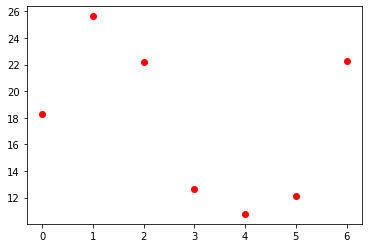

In [23]:
import matplotlib.pyplot as plt 

train_df["day"] = train_df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000.0).weekday())
for day in range(7):
    plt.plot(day, np.mean(train_df[train_df["day"]==day]["retweets_count"]),'ro')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

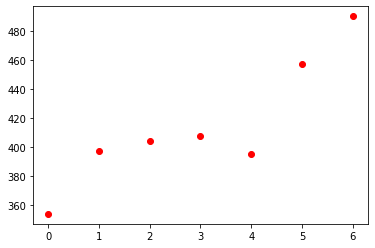

In [24]:
train_df["hour"] = train_df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000.0).weekday())
for hour in range(7):
    plt.plot(hour, np.mean(train_df[(train_df["hour"]==hour) & (train_df["favorites_count"]>100)]["retweets_count"]),'ro')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

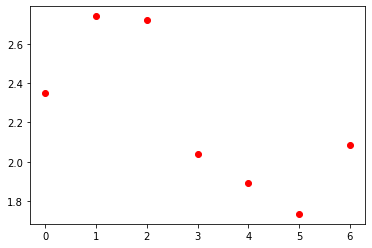

In [25]:
train_df["hour"] = train_df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000.0).weekday())
for hour in range(7):
    plt.plot(hour, np.mean(train_df[(train_df["hour"]==hour) & (train_df["favorites_count"]<=100)]["retweets_count"]),'ro')
plt.show

In [26]:
from math import log10
def pre_process(df, train=True):
    if train:
        df["logrt"] = df.retweets_count.map(lambda x: log10(x+1))
    df["logfav"] = df.favorites_count.map(lambda x: log10(x+1))
    df["logfriend"] = df.friends_count.map(lambda x: log10(x+1))
    df["logstatus"] = df.statuses_count.map(lambda x: log10(x+1))
    df["text_len"] = df.text.map(lambda x: len(x)/140)
    df["word_count"] = df.text.map(lambda x: len(x.split())/140)
    df["normed_time"] = df.timestamp.map(lambda t: log10(1.64775e12 - t))
    for w in important_words:
        df[w] = df.text.map(lambda t: 1 if w in [word.lower() for word in t] else 0)
    df["hour"] = df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000.0).hour)
    df["day"] = df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000.0).weekday())
    Xt = df[["logfav", "text_len", "logfriend", "word_count", "logstatus", "normed_time", "verified", *important_words]].values
    if train:
        yt = df["retweets_count"].values[:, None]
        return Xt, yt
    else:
        return Xt

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
class print_training_on_text_every_10_epochs_Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if(int(epoch) % 200) == 0:
            if 'val_loss' in logs:
                print("Epoch: {:>3} | Loss: ".format(epoch) + f"{logs['loss']:.4e}"\
                      + " | Valid loss: " + f"{logs['val_loss']:.4e}")
            else:
                print("Epoch: {:>3} | Loss: ".format(epoch) + f"{logs['loss']:.4e}")

lr0 = 0.003
decrease_start = 40
def schedule(epoch, lr):
    if epoch < decrease_start:
        return lr0
    return lr0 * decrease_start/ epoch
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule , verbose=0)
my_callbacks = [
  print_training_on_text_every_10_epochs_Callback(),scheduler
  ]

In [29]:
X_test = pre_process(ev_df, train=False)
import csv

In [30]:
#attempts = [(i-gap,i) for i in range(60, 110, 4) for gap in [0, 5, 10, 15]]
attempts = [(100,100)]
scores = []
for thresh, eval_tresh in attempts:
    print()
    print(thresh, eval_tresh)

    xltdf = train_df[train_df["favorites_count"] > thresh].copy()
    X_train, y_train = pre_process(xltdf)
    X_val, y_val = pre_process(val_df)

    n_train, n_features = X_train.shape
    print(n_train, n_features)

    inputs = keras.Input(shape=(n_features,), name="digits")
    x = inputs
    #x = layers.Dense(64, activation="relu", name="dense_1")(x)
    x = layers.Dense(64, activation="relu", name="dense_1")(x)
    x = layers.Dense(1, activation="linear", name="dense_2")(x)
    x = tf.keras.activations.exponential(x)
    x = layers.Dense(1, kernel_initializer=tf.keras.initializers.Ones(), activation="linear", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=x)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.003),
        loss=tf.keras.losses.MeanAbsoluteError(
        reduction="auto", name="mean_absolute_error"
    ),
    )

    history = model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=2000,
        verbose=0,
        callbacks=my_callbacks
    )

    val_predictions = model.predict(X_val)

    losses_tree = []
    losses_nn = []
    for i, (_, row) in enumerate(val_df.iterrows()):
        if row['favorites_count'] <= eval_tresh:
            losses_tree.append(abs(val_preds[i] - y_val[i]).item())
        else:
            losses_nn.append(abs(val_predictions[i] - y_val[i]).item())

    y_ = train_df[train_df["favorites_count"] <= thresh]["retweets_count"].values
    print("nn difficulty", "tree difficulty")
    print((y_train - np.median(y_train)).mean(), (y_ - np.median(y_)).mean())
    print("tree",sum(losses_tree) / len(losses_tree), sum(losses_tree))
    print("nn",sum(losses_nn) / len(losses_nn), sum(losses_nn))
    losses = losses_nn + losses_tree
    overall = sum(losses) / len(losses)
    print("overall",overall)
    scores.append((overall, thresh, eval_tresh))
    
    y_test = model.predict(X_test)[:, 0]
    name = f"predictions{thresh}_{eval_tresh}.txt"
    with open(name, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["TweetID", "retweets_count"])
        for i, row in ev_df.iterrows():
            pred = preds[i] if row['favorites_count'] <= eval_tresh else y_test[i]
            writer.writerow([row['TweetID'], str(int(pred))])
    read_file = pd.read_csv (f"predictions{thresh}_{eval_tresh}.txt")
    read_file.to_csv (f"predictions{thresh}_{eval_tresh}.csv", index=None)
print(min(scores))


100 100
10790 17


2022-11-30 15:20:16.227152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 15:20:16.228137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 15:20:16.505513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 15:20:16.506293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 15:20:16.507095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch:   0 | Loss: 2.5072e+02
Epoch: 200 | Loss: 1.4874e+02
Epoch: 400 | Loss: 1.4644e+02
Epoch: 600 | Loss: 1.4529e+02
Epoch: 800 | Loss: 1.4377e+02
Epoch: 1000 | Loss: 1.4374e+02
Epoch: 1200 | Loss: 1.4336e+02
Epoch: 1400 | Loss: 1.4330e+02
Epoch: 1600 | Loss: 1.4291e+02
Epoch: 1800 | Loss: 1.4277e+02
nn difficulty tree difficulty
290.04504170528264 2.1351670987907023
tree 1.247152286932648 42700.0
nn 141.8997601969063 164461.82206821442
overall 5.852524848665548
(5.852524848665548, 100, 100)
